Онлайн-платформа по типу Youtube хочет улучшить персонализацию контента, предлагая пользователям более релевантные видео, статьи или публикации.   

**Цель проекта:**

Разработать систему, которая (с явного согласия пользователя) анализирует загруженные им фотографии профиля или видео для определения его возраста, пола и расы. Эта информация используется для формирования более точных рекомендаций контента.

**Решение:**

Использовать многоклассовый мультилейбл классификатор изображений для предсказания возраста, пола и расы пользователя.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

In [4]:
import zipfile
import os
import pandas as pd
import re
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Загрузка изображений

In [29]:
def extract_and_process_tar_gz_fixed(tar_gz_files, output_dir="processed_images"):
    os.makedirs(output_dir, exist_ok=True)
    data = []
    for tar_gz_path in tar_gz_files:
        try:
            with tarfile.open(tar_gz_path, 'r:gz') as tar_ref:
                for member in tar_ref.getmembers():
                    if member.isfile() and member.name.endswith(".jpg"):
                        try:
                            file_name = os.path.basename(member.name)
                            parts = file_name.split('_')
                            if len(parts) == 4:
                                age = int(parts[0])
                                gender = int(parts[1])
                                race = int(parts[2])
                                img_id = parts[3].split('.')[0]

                                # Извлекаем изображение
                                with tar_ref.extractfile(member) as source:
                                    img = Image.open(source)
                                    if img.mode == "RGBA":
                                        img = img.convert("RGB")  # Преобразуем RGBA в RGB

                                    output_path = os.path.join(output_dir, file_name)
                                    img.save(output_path, "JPEG")  # Явно указываем формат JPEG

                                    data.append({
                                        'image_path': output_path,
                                        'age': age,
                                        'gender': gender,
                                        'race': race,
                                        'id': img_id
                                    })
                            else:
                                print(f"Предупреждение: Неожиданный формат имени файла: {file_name} в архиве {tar_gz_path}")
                        except Exception as e:
                            print(f"Ошибка при обработке файла {member.name} из архива {tar_gz_path}: {e}")
        except tarfile.ReadError as e:
            print(f"Ошибка при чтении tar.gz архива {tar_gz_path}: {e}")

    return pd.DataFrame(data)

In [19]:
os.listdir('.')

['.ipynb_checkpoints',
 'Lab7.ipynb',
 'part1.tar.gz',
 'part2.tar.gz',
 'part3.tar.gz',
 'UTKface_inthewild',
 'utkface_processed_subfolders',
 'Лабораторная работа 7.docx']

In [31]:
tar_gz_files_in_current_dir = [f for f in os.listdir('.') if f.endswith('.tar.gz')]
print(f"Найденные tar.gz архивы: {tar_gz_files_in_current_dir}")

Найденные tar.gz архивы: ['part1.tar.gz', 'part2.tar.gz', 'part3.tar.gz']


In [33]:
output_image_directory = 'utkface_processed_targz'
# Извлекаем изображения и метаданные
metadata_df = extract_and_process_tar_gz_fixed(tar_gz_files_in_current_dir, output_image_directory)

Предупреждение: Неожиданный формат имени файла: 61_3_20170109150557335.jpg в архиве part1.tar.gz
Предупреждение: Неожиданный формат имени файла: 61_1_20170109142408075.jpg в архиве part1.tar.gz
Предупреждение: Неожиданный формат имени файла: 39_1_20170116174525125.jpg в архиве part2.tar.gz
Ошибка при обработке файла part2/53__0_20170116184028385.jpg из архива part2.tar.gz: invalid literal for int() with base 10: ''


In [35]:
def load_and_display_random_images(image_dir, num_images=5):
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    if not image_files:
        print(f"В директории {image_dir} не найдено изображений.")
        return

    num_to_display = min(num_images, len(image_files))
    random_image_files = random.sample(image_files, num_to_display)

    print(f"Отображение {num_to_display} случайных изображений из {image_dir}:")
    fig, axes = plt.subplots(1, num_to_display, figsize=(15, 5))
    if num_to_display == 1:
        axes = [axes]  # Для корректной работы с одним изображением

    for i, img_file in enumerate(random_image_files):
        try:
            img_path = os.path.join(image_dir, img_file)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(img_file, fontsize=8)
        except Exception as e:
            print(f"Ошибка при загрузке изображения {img_file}: {e}")

    plt.tight_layout()
    plt.show()

Отображение 5 случайных изображений из utkface_processed_targz:


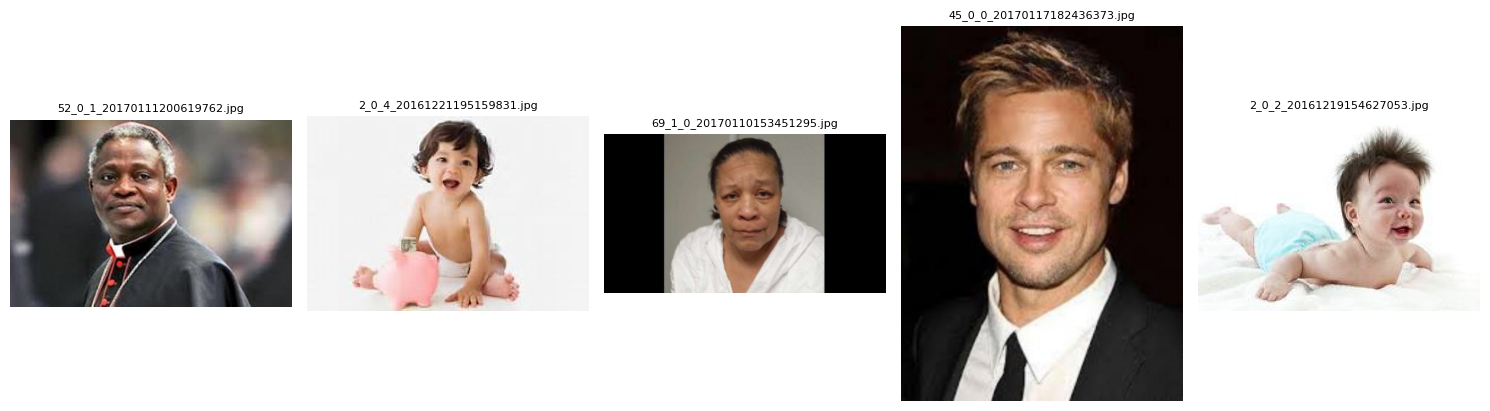

In [37]:
image_directory = 'utkface_processed_targz'  # Замените на фактический путь к вашей директории с изображениями
load_and_display_random_images(image_directory, num_images=5)

# После перезапуска

In [7]:
def create_metadata_df(root_dir):
    file_paths = []
    ids = []
    ages = []
    genders = []
    races = []

    for filename in os.listdir(root_dir):
        if filename.endswith(".jpg"):
            match = re.match(r"(\d+)_(\d)_(\d)_(\d+)\.jpg", filename)
            if match:
                age, gender, race, file_id = match.groups()
                file_path = os.path.join(root_dir, filename)
                file_paths.append(file_path)
                ids.append(file_id)
                ages.append(int(age))
                genders.append(int(gender))
                races.append(int(race))

    df = pd.DataFrame({
        'image_path': file_paths,
        'id': ids,
        'age': ages,
        'gender': genders,
        'race': races
    })
    return df

In [8]:
root_directory = 'utkface_processed_targz'  # Замените на фактический путь
# Создайте DataFrame
metadata_df = create_metadata_df(root_directory)
metadata_df.drop_duplicates(subset=['id'], keep='first', inplace = True)

In [12]:
metadata_df

,image_path,id,age,gender,race
0,utkface_processed_targz\100_0_0_20170112213500...,20170112213500903,100,0,0
1,utkface_processed_targz\100_0_0_20170112215240...,20170112215240346,100,0,0
2,utkface_processed_targz\100_1_0_20170110183726...,20170110183726390,100,1,0
3,utkface_processed_targz\100_1_0_20170112213001...,20170112213001988,100,1,0
4,utkface_processed_targz\100_1_0_20170112213303...,20170112213303693,100,1,0
...,...,...,...,...,...
24096,utkface_processed_targz\9_1_3_2016122022285634...,20161220222856346,9,1,3
24097,utkface_processed_targz\9_1_3_2017010422294945...,20170104222949455,9,1,3
24098,utkface_processed_targz\9_1_4_2017010320063739...,20170103200637399,9,1,4
24099,utkface_processed_targz\9_1_4_2017010320081479...,20170103200814791,9,1,4


# Выделение классов

In [18]:
def categorize_age(age):
    if 0 <= age <= 12:
        return 'child'
    elif 13 <= age <= 19:
        return 'teenager'
    elif 20 <= age <= 35:
        return 'young_adult'
    elif 36 <= age <= 60:
        return 'adult'
    elif 61 <= age <= 75:
        return 'senior'
    else:
        return 'elder'

In [20]:
metadata_df['age_group'] = metadata_df['age'].apply(categorize_age)

In [22]:
def one_hot_encode_multilabel(metadata_df):
    gender_ohe = pd.get_dummies(metadata_df['gender'], prefix='gender')
    metadata_df = pd.concat([metadata_df, gender_ohe], axis=1)
    metadata_df.drop('gender', axis=1, inplace=True)

    race_ohe = pd.get_dummies(metadata_df['race'], prefix='race')
    metadata_df = pd.concat([metadata_df, race_ohe], axis=1)
    metadata_df.drop('race', axis=1, inplace=True)

    age_ohe = pd.get_dummies(metadata_df['age_group'], prefix='age')
    metadata_df = pd.concat([metadata_df, age_ohe], axis=1)
    metadata_df.drop(['age_group', 'age', 'id'], axis=1, inplace=True)    
    return metadata_df

In [24]:
metadata_df_ohe = one_hot_encode_multilabel(metadata_df.copy())

In [26]:
metadata_df_ohe

,image_path,gender_0,gender_1,race_0,race_1,race_2,race_3,race_4,age_adult,age_child,age_elder,age_senior,age_teenager,age_young_adult
0,utkface_processed_targz\100_0_0_20170112213500...,True,False,True,False,False,False,False,False,False,True,False,False,False
1,utkface_processed_targz\100_0_0_20170112215240...,True,False,True,False,False,False,False,False,False,True,False,False,False
2,utkface_processed_targz\100_1_0_20170110183726...,False,True,True,False,False,False,False,False,False,True,False,False,False
3,utkface_processed_targz\100_1_0_20170112213001...,False,True,True,False,False,False,False,False,False,True,False,False,False
4,utkface_processed_targz\100_1_0_20170112213303...,False,True,True,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24096,utkface_processed_targz\9_1_3_2016122022285634...,False,True,False,False,False,True,False,False,True,False,False,False,False
24097,utkface_processed_targz\9_1_3_2017010422294945...,False,True,False,False,False,True,False,False,True,False,False,False,False
24098,utkface_processed_targz\9_1_4_2017010320063739...,False,True,False,False,False,False,True,False,True,False,False,False,False
24099,utkface_processed_targz\9_1_4_2017010320081479...,False,True,False,False,False,False,True,False,True,False,False,False,False


# Обучение моделей

In [28]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        labels = self.dataframe.iloc[idx][['gender_0', 'gender_1', 'race_0', 'race_1', 'race_2',
       'race_3', 'race_4', 'age_adult', 'age_child', 'age_elder', 'age_senior',
       'age_teenager', 'age_young_adult']].values.astype(np.float32)

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels)

In [30]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [34]:
train_df, test_df = train_test_split(metadata_df_ohe, test_size=0.2, random_state=42, shuffle=True)
train_dataset = ImageDataset(train_df, transform=data_transforms)
test_dataset = ImageDataset(test_df, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

## ResNet

In [36]:
model = models.resnet50(weights=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 13)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
def train_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [60]:
from sklearn.metrics import f1_score, accuracy_score

In [74]:
def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            predictions = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = accuracy_score(np.array(all_labels), np.array(all_predictions)) # Используем F1-score
    return epoch_loss, accuracy

In [76]:
def train(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10):
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_loss = train_epoch(model, criterion, optimizer, train_loader, device)
        print(f'Train Loss: {train_loss:.4f}')
        test_loss, test_accuracy = evaluate_model(model, criterion, val_loader, device)
        print(f'test Loss: {test_loss:.4f}, test accuracy-score: {test_accuracy:.4f}')

    return model

In [78]:
trained_model = train(model, criterion, optimizer, train_loader, test_loader, device, num_epochs=10)

Epoch 0/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:30<00:00,  4.41it/s]


Train Loss: 0.2876


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:06<00:00,  4.50it/s]


test Loss: 0.2665, test accuracy-score: 0.2608
Epoch 1/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:28<00:00,  4.44it/s]


Train Loss: 0.2843


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:04<00:00,  4.61it/s]


test Loss: 0.2728, test accuracy-score: 0.2354
Epoch 2/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:34<00:00,  4.36it/s]


Train Loss: 0.2838


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.15it/s]


test Loss: 0.2795, test accuracy-score: 0.2643
Epoch 3/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:49<00:00,  4.12it/s]


Train Loss: 0.2806


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.17it/s]


test Loss: 0.2720, test accuracy-score: 0.2564
Epoch 4/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:36<00:00,  4.32it/s]


Train Loss: 0.2799


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.44it/s]


test Loss: 0.2624, test accuracy-score: 0.2470
Epoch 5/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:34<00:00,  4.35it/s]


Train Loss: 0.2779


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.42it/s]


test Loss: 0.2733, test accuracy-score: 0.2394
Epoch 6/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:32<00:00,  4.38it/s]


Train Loss: 0.2766


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:06<00:00,  4.48it/s]


test Loss: 0.2684, test accuracy-score: 0.2711
Epoch 7/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:30<00:00,  4.41it/s]


Train Loss: 0.2759


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:06<00:00,  4.51it/s]


test Loss: 0.2672, test accuracy-score: 0.2482
Epoch 8/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:32<00:00,  4.38it/s]


Train Loss: 0.2744


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.57it/s]


test Loss: 0.2719, test accuracy-score: 0.2359
Epoch 9/9
----------


Training: 100%|████████████████████████████████████████████████████████████████████| 1194/1194 [04:32<00:00,  4.38it/s]


Train Loss: 0.2755


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.59it/s]

test Loss: 0.2676, test accuracy-score: 0.2166
